# Introduction

As the healthcare system moves toward value-based care, CMS has created many programs to improve the quality of care of patients. One of these programs is called the Hospital Readmission Reduction Program (HRRP), which reduces reimbursement to hospitals with above average readmissions. For those hospitals which are currently penalized under this program, one solution is to create interventions to provide additional assistance to patients with increased risk of readmission. But how do we identify these patients? We can use predictive modeling from data science to help prioritize patients.

One patient population that is at increased risk of hospitalization and readmission is that of diabetes. Diabetes is a medical condition that affects approximately 1 in 10 patients in the United States. According to Ostling et al, patients with diabetes have almost double the chance of being hospitalized than the general population (Ostling et al 2017). Therefore, in this project, I will focus on predicting hospital readmission for patients with diabetes.

Reference: Ostling, Wyckoff, Ciarkowski, Pai, Choe, Bahl, Gianchandani (2017). “The relationship between diabetes mellitus and 30-day readmission rates” in Clinical Diabetes and Endocrinology. 3:1

# Dataset

The data that is used in this project originally comes from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999–2008.

# Project Definition

Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

# Data Exploration

In [2]:
# load the csv into a dataframe
import pandas as pd
df = pd.read_csv('Patient_Readmission.csv')

In [3]:
print('Number of samples:',len(df))

Number of samples: 101766


In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

 If we look at the IDs_mapping.csv we can see that discharge disposition id (where did patient go after hospital) 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model. 

In [6]:
# look at discharge_disposition_id (tells us where patient went after the hospitalization)
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

In [7]:
# remove these rows from the file
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [8]:
# create an output label
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

In [9]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

In [10]:
print('prevalence of the positive class: %.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

prevalence of the positive class: 0.114


Around 11% of the population is rehospitalized.

Now we would like to get a feeling of the data for each column in our dataset. Pandas doesn't allow you to see all the columns at once, so let's look at them in groups of 10. 

In [11]:
print('Number of columns:',len(df.columns))

Number of columns: 51


In [12]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


In [13]:
df[list(df.columns)[10:20]].head()

,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2
0,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?
1,?,?,59,0,18,0,0,0,276,250.01
2,?,?,11,5,13,2,0,1,648,250
3,?,?,44,1,16,0,0,0,8,250.43
4,?,?,51,0,8,0,0,0,197,157


In [14]:
df[list(df.columns)[20:30]].head()

,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide
0,?,1,None,None,No,No,No,No,No,No
1,255,9,None,None,No,No,No,No,No,No
2,V27,6,None,None,No,No,No,No,No,No
3,403,7,None,None,No,No,No,No,No,No
4,250,5,None,None,No,No,No,No,No,No


In [15]:
df[list(df.columns)[30:40]].head()

,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide
0,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No
2,Steady,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No
4,Steady,No,No,No,No,No,No,No,No,No


In [16]:
df[list(df.columns)[40:]].head()

,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,OUTPUT_LABEL
0,No,No,No,No,No,No,No,No,No,NO,0
1,No,Up,No,No,No,No,No,Ch,Yes,>30,0
2,No,No,No,No,No,No,No,No,Yes,NO,0
3,No,Up,No,No,No,No,No,Ch,Yes,NO,0
4,No,Steady,No,No,No,No,No,Ch,Yes,NO,0


From this, we see that there are a lot of categorical (non-numeric) variables. Note that the variables with _id are also categorical and you can see what the ids refer to with the IDs_mapping.csv. Let's take a look at the unique values for each column. 

In [17]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 

From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out, 

    - encounter_id and patient_nbr: these are just identifiers and not useful variables
    - age and weight: are categorical in this data set
    - admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 
    - examide and citoglipton only have 1 value, so we will not use these variables
    - diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
    - medical_speciality - has many categorical variables, so we should consider this when making features. 

# Feature Engineering

In this section, we will create features for our predictive model. For each section, we will add new variables to the dataframe and then keep track of which columns of the dataframe we want to use as part of the predictive model features. We will break down this section into numerical features, categorical features and extra features. 

In this data set, the missing numbers were filled with a question mark. Let's replace it with a nan representation.

In [18]:
import numpy as np

In [19]:
# replace ? with nan
df = df.replace('?',np.nan)

## Numerical Features

The easiest type of features to use is numerical features. These features do not need any modification. The columns that are numerical that we will use are shown below

In [20]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

Let's check if there are any missing values in the numerical data. 

In [21]:
df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Categorical Features

The next type of features we want to create are categorical variables. Categorical variables are non-numeric data such as race and gender. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding, which will be explained below. 

The first set of categorical data we will deal with are these columns:

In [22]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

Let's check if there are any missing data

In [23]:
df[cols_cat+['medical_specialty']].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
medical_specialty           48616
dtype: int64

`race`, `payer_code`, and `medical_specialty` have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the `fillna` function. 

In [24]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Let's investigate medical specialty before we begin. 

In [25]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Psychiatry-Addictive                    1
Dermatology                             1
Speech                                  1
SportsMedicine                          1
Surgery-PlasticwithinHeadandNeck        1
Length: 73, dtype: int64

We can see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category). Obviously, there are other options for bucketing, but this is one of the easiest methods. 

In [26]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [27]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the `get_dummies` function. I like to use the prefix option so we can trace back to the original column. Compare the outputs from the two dataframes below to verify you understand one-hot encoding. 

In [28]:
df.race.head()

0          Caucasian
1          Caucasian
2    AfricanAmerican
3          Caucasian
4          Caucasian
Name: race, dtype: object

In [29]:
pd.get_dummies(df['race'],prefix = 'race').head()

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


Now the problem is that if we create a column for each unique value, we have correlated columns. In other words, the value in one column can be figured out by looking at the rest of the columns. For example, if the sample is not AfricanAmerican, Asian, Causasian, Hispance or Other, it must be UNK. To deal with this, we can use the `drop_first` option, which will drop the first categorical value. 

In [30]:
pd.get_dummies(df['race'],prefix = 'race', drop_first = True).head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


Now it would be annoying to have to use get_dummies for each categorical column. Luckily, we can send all the columns at once into the get_dummies function and use the column name as the prefix. 

In [31]:
pd.get_dummies(df[cols_cat],drop_first = True).head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


What happens if you send the 3 ID columns into get_dummies?

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly. 

In [32]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
pd.get_dummies(df[cols_cat_num],drop_first = True).head()

,admission_type_id,discharge_disposition_id,admission_source_id
0,6,25,1
1,1,1,7
2,1,1,7
3,1,1,7
4,1,1,7


You just get the 3 columns back. What happened? The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly. 

In [33]:
df[cols_cat_num] = df[cols_cat_num].astype('str')

In [34]:
pd.get_dummies(df[cols_cat_num],drop_first = True).head()

,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,...,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Now we are ready to make all of our categorical features

In [35]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [36]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


To add the one-hot encoding columns to the dataframe we can use `concat` function. Make sure to use axis = 1 to indicate add the columns. 

In [37]:
df = pd.concat([df,df_cat], axis = 1)

Save the column names of the categorical data. 

In [38]:
cols_all_cat = list(df_cat.columns)

## Ordinal Features

The last two columns we want to make features are `age` and `weight`. Typically, you would think of these as numerical data, but they are categorical in this dataset as shown below. 

In [39]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


One option could be to create categorical data as shown above. Since there is a natural order to these values, it might make more sense to convert these to numerical data. Another example when you would want to do this might be size of a t-shirt (small, medium, large). Let's start with age. 

In [40]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data. 

In [41]:
age_id = {'[0-10)':0, 
          '[10-20)':1, 
          '[20-30)':2, 
          '[30-40)':3, 
          '[40-50)':4, 
          '[50-60)':5,
          '[60-70)':6, 
          '[70-80)':7, 
          '[80-90)':8, 
          '[90-100)':9}
df['age_group'] = df.age.replace(age_id)

Now let's look at weight. Recall that this feature is not filled out very often.  

In [42]:
df.weight.notnull().sum()

3125

Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value.


In [43]:
df['has_weight'] = df.weight.notnull().astype('int')

In [44]:
cols_extra = ['age_group','has_weight']

## Engineering Features Summary

In [45]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


Let's check if we are missing any data. 

In [46]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

has_weight              0
pioglitazone_No         0
acarbose_No             0
rosiglitazone_Up        0
rosiglitazone_Steady    0
rosiglitazone_No        0
pioglitazone_Up         0
pioglitazone_Steady     0
tolbutamide_Steady      0
acarbose_Up             0
dtype: int64

This looks good. I'll mention later one technique for filling missing data. 

let's make a new dataframe that only has the columns of interest

In [47]:
cols_input = cols_num + cols_all_cat + cols_extra
df_data = df[cols_input + ['OUTPUT_LABEL']]

Double check that the columns used to define your OUTPUT_LABEL are not part of cols_input! 

# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts:
    - Training samples: these samples are used to train the model
    - Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model
    - Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model
  
In this tutorial, we will split into 70% train, 15% validation, 15% test. 

The first thing I like to do is to shuffle the samples using `sample` in case there was some order (e.g. all positive samples on top). Here `n` is the number. `random_state` is just specified so the entire class gets the same shuffling. You wouldn't need `random_state` in your own projects. 

In [48]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

We can use sample again to extract 30% (using frac) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it. 

In [49]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction. 

In [50]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

Note that `.drop` just drops the rows from `df_test` to get the rows that were not part of the sample. We can use this same idea to get the training data. 

In [51]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance.

In [52]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


Let's verify that we used all the data.

In [53]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 99343)


At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen? 

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative.

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:

- sub-sample the more dominant class: use a random subset of the negatives
- over-sample the imbalanced class: use the same positive samples multiple times
- create synthetic positive data

Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement.


In [54]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


Since we have done a lot of work, let's save our data and start the next part of the tutorial in XYZ.ipynb. Note that `index = False` just drops the index from the csv. 

In [55]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Let's save the cols_input too with a package called `pickle`. 

In [56]:
import pickle
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

All machine learning algorithms in sci-kit learn (python package for ML models) cannot handle missing values. Let's create a function to fill in the missing values with the mean. This is a design decision. 

In [57]:
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

Calculate the mean value from the training data. 

In [58]:
df_mean = df_train_all[cols_input].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

/Users/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
df_mean_in.head()

,col,mean_val
0,time_in_hospital,4.375482
1,num_lab_procedures,42.889071
2,num_procedures,1.330141
3,num_medications,15.971815
4,number_outpatient,0.366365


In [60]:
df_train_all = fill_my_missing(df_train_all, df_mean_in, cols_input)
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [61]:
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler  which removes the mean and scales to unit variance. Here I will create a scaler using all the training data, but you could use the balanced one if you wanted. 

In [62]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler(copy=True, with_mean=True, with_std=True)

We will need this scaler for the test data, so let's save it using a package called `pickle`. 

In [63]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [64]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [65]:
# transform our data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

Wow! so much work to get ready for a model. This is always true in data science. You spend 80-90% cleaning and preparing data. 

In this section, we train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

We will utilize the following functions to evaluate the performance of the model. An explanation of these metrics will be provided at the beginning of week 3. 

In [66]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive. 

In [67]:
thresh = 0.5

## Model Selection: baseline models

In this section, we will compare the performance of 7 machine learning models using default hyperparameters. 

### K nearest neighbors (KNN)

In [68]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [69]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


Our first model did pretty well. We have an AUC of 0.62 that catches 47% of the hospitalizations when we use a threshold of 0.5. Good job. Now it is your turn to do this on your own project! Next week we will talk about a few other predictive model algorithms! 

### Logistic regression

In [70]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.662
recall:0.558
precision:0.180
specificity:0.675
prevalence:0.113
 


### Stochastic Gradient Descent

In [72]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [73]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.676
accuracy:0.624
recall:0.550
precision:0.645
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.664
recall:0.553
precision:0.180
specificity:0.678
prevalence:0.113
 


### Naive Bayes

In [74]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [75]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.508
accuracy:0.506
recall:0.989
precision:0.503
specificity:0.022
prevalence:0.500
 
Validation:
AUC:0.505
accuracy:0.129
recall:0.988
precision:0.114
specificity:0.020
prevalence:0.113
 


### Decision Tree Classifier

In [76]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [77]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.736
accuracy:0.672
recall:0.629
precision:0.688
specificity:0.713
prevalence:0.500
 
Validation:
AUC:0.623
accuracy:0.636
recall:0.570
precision:0.170
specificity:0.642
prevalence:0.113
 


### Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [79]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.681
accuracy:0.631
recall:0.591
precision:0.642
specificity:0.670
prevalence:0.500
 
Validation:
AUC:0.648
accuracy:0.631
recall:0.577
precision:0.169
specificity:0.638
prevalence:0.113
 


### Gradient Boosting Classifier

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [81]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.772
accuracy:0.695
recall:0.668
precision:0.706
specificity:0.722
prevalence:0.500
 
Validation:
AUC:0.638
accuracy:0.620
recall:0.574
precision:0.164
specificity:0.626
prevalence:0.113
 


## Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold. 

In [82]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

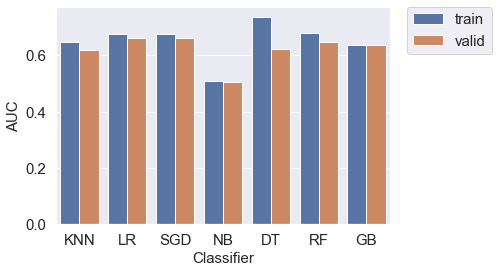

In [84]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

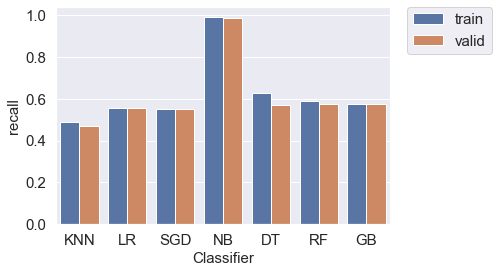

In [85]:
ax = sns.barplot(x="classifier", y="recall", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

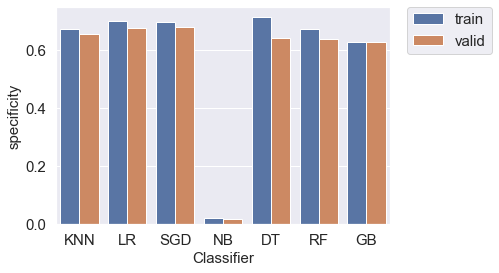

In [86]:
ax = sns.barplot(x="classifier", y="specificity", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('specificity', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

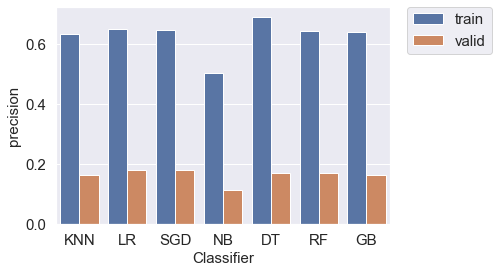

In [87]:
ax = sns.barplot(x="classifier", y="precision", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('precision', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

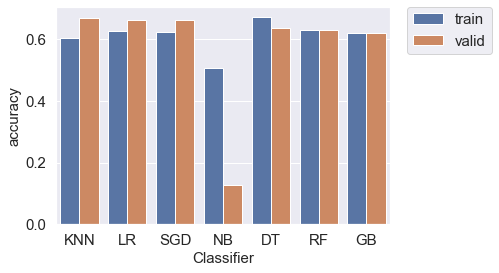

In [88]:
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

## Model Selection: Learning Curves

In this section, we will make use of the learning curve code from scikit-learn's website. http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. 

In [89]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

A complex Random Forest with max_depth = 20, resulting in high variance. 

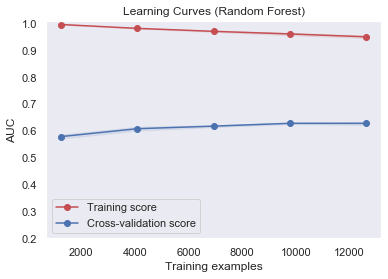

In [90]:
from sklearn.ensemble import RandomForestClassifier
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 20, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

A simple Random Forest with max_depth = 3, resulting in high bias. 

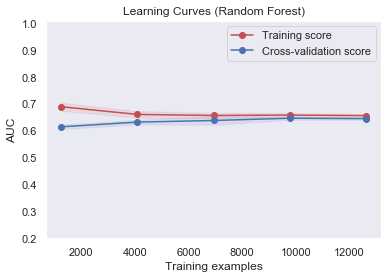

In [91]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 3, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the first case, we see that there is a large difference between the training and validation scores. This is known as high variance and is a sign of overfitting. In the second case, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting. Note that you will usually just have one learning curve - the one for your 'best model' so far. The examples above were created to show you the two types of learning curves.  

Depending on your learning curve, there are a few strategies you can employ to improve your models

High Bias:

    Add new features
    Increase model complexity
    Reduce regularization
    Change model architecture

High Variance:

    Add more samples
    Add regularization
    Reduce number of features
    Decrease model complexity
    Add better features
    Change model architecture

Source: Andrew Ng's Coursera class paraphrased on https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/ and Andrew Ng's Machine Learning Yearning textbook.

In the remainder of this tutorial, we will discuss some of the hyperparameters (options) for a few of the machine learning models with respect to these strategies above.


## Model Selection: Feature Importance

One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests. This analysis can help in a few areas:
    
    - inspire new feature ideas --> helps with both high bias and high variance
    - obtain a list of the top features to be used for feature reduction --> helps with high variance
    - point out errors in your pipeline --> helps with robustness of model

Let's get the feature importance for a few models and then we can discuss what we see. 


### Feature Importance: logistic regression

Logistic regression is a very interpretable model because the coefficient for each variable shows how important that variable is for the prediction. Note that you need to have normalized the data so the coefficients are comparable between variables. 

In [92]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We can extract the coefficients using `coef_` and store in a new dataframe (sorted by importance) 

In [93]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [94]:
feature_importances.head()

,importance
number_inpatient,0.356977
rosiglitazone_No,0.283933
rosiglitazone_Steady,0.238041
discharge_disposition_id_22,0.202501
repaglinide_No,0.170693


For logistic regression, the variables with highest positive coefficients are predictive of re-hospitalization and the variables with highest negative coefficients are predictive of not being re-hospitalized. We can plot the top 50 for each direction below. Note that if you don't have a lot of features, this may show the negative coefficients too. 

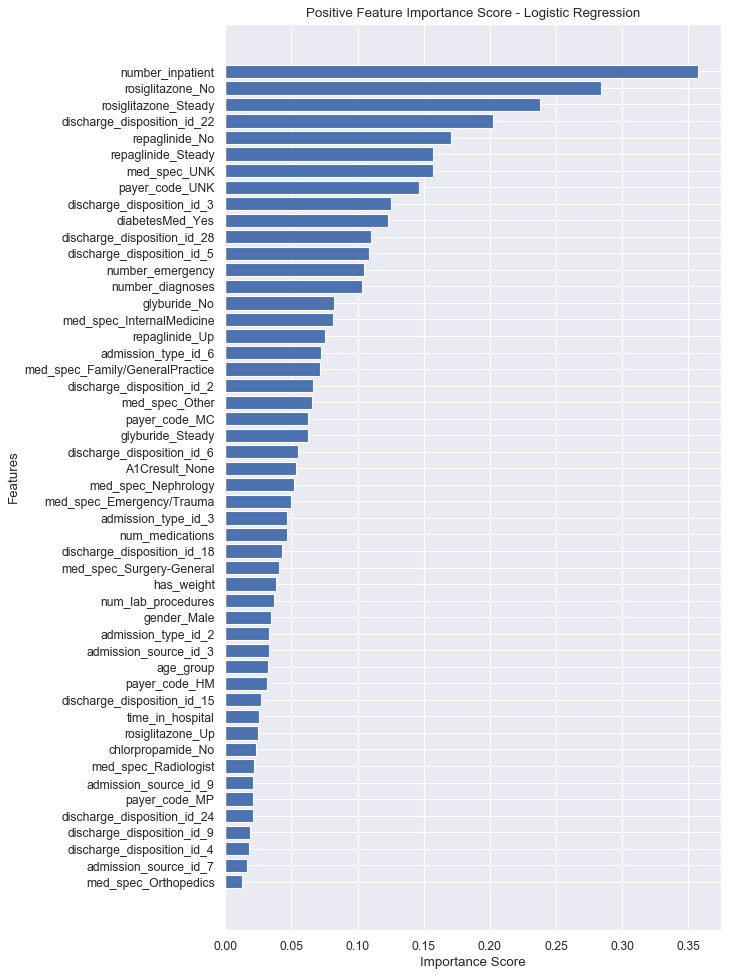

In [95]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

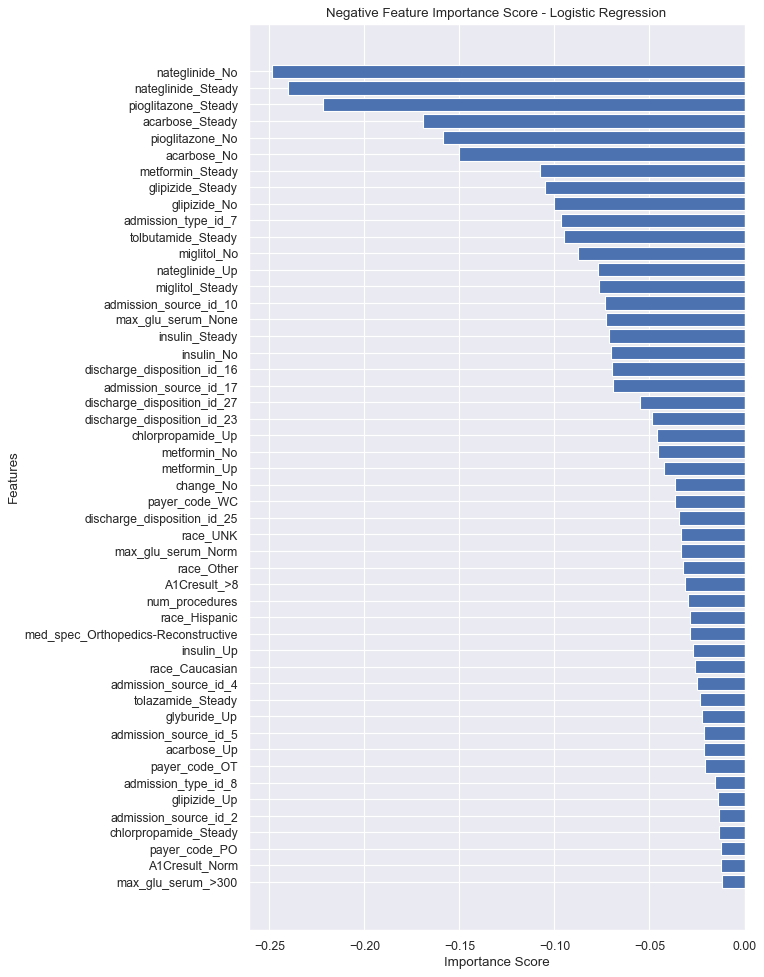

In [96]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

### Model Selection: random forest

We can also investigate feature importance for random forest (or grad boosting) models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision. 

In [97]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [98]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
number_inpatient,0.300483
number_emergency,0.120202
discharge_disposition_id_22,0.089470
num_medications,0.062188
time_in_hospital,0.054703


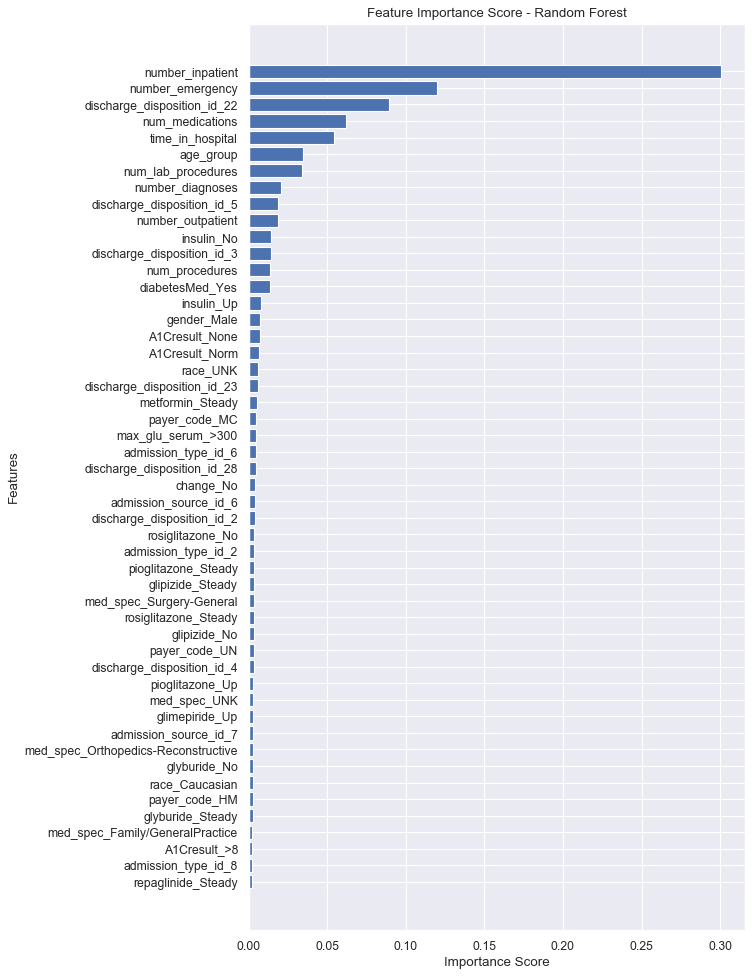

In [99]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

As you can see here, most of the important variables for random forest are continuous variables. This makes sense since you can split continuous variables more times than categorical variables. 

After reviewing these plots, you might be inspired to get some new data related to the most important features. For example, in both models the most important feature is `number_inpatient`, which is the number of inpatient visits in the last year. This means that if patients have been to the hospital in the last year they are more likely to be re-hospitalized again. This might inspire you to get (if you have it) more data about their prior admissions.Another example is `discharge_disposition_id_22` which is used if a patient is discharged to a rehab facility. For your company, you might be able to research rules for being discharged to a rehab facility and add features related to those rules. Since most of the data analysts / data scientists won't have the deep domain knowledge. I probably would take a few of these features to other experts (e.g. doctors) and ask them about the medications.  

In the case of high variance, one strategy is to reduce the number of variables to minimize overfitting. After this analyis, you could use the top N positive and negative features or the top N important random forest features. You might need to adjust N so that your performance does not drop drastically. For example, only using the top feature will likely drop the performance by a lot. Another strategy that you could use to reduce the number of variables is called PCA (principle component analysis). This is also implemented in scikit-learn if you are interested. 

The last thing that I want to mention is that the feature importance plots may also point out errors in your predictive model. Perhaps, you have some data leakage in the cleaning process. Data leakage can be thought of as the process of accidentally including something in the training that allows the machine learning algorithm to artificially cheat. For example, I built a model based on the doctor's discharge notes. When I performed this same analysis on the most important words, I discovered that the top word for predicting someone would not be re-admitted was 'death'. This made me realize that I made a mistake and forgot to exclude patients who expired in the current hospital visit. Learning from my mistakes, I had you exclude the discharge codes related to death. Similar things can also happen when you merge datasets. Perhaps when you merged the datasets one of the classes ended up with nan for some of the variables. The analysis above will help you catch some of these cases.  

## Model Selection: Hyperparameter Tuning

The next thing that we should investigate is hyperparameter tuning. Hyperparameter tuning are essentially the design decisions that you made when you set up the machine learning model. For example, what is the maximum depth for your random forest? Each of these hyperparameters can be optimized to improve the model. 

Let's begin by looking at the effect of a single parameter for random forest: `max_depth`. `max_depth` controls the depth of the tree. 

In [100]:
# train a model for each max_depth in a list. Store the auc for the training and validation set

# max depths
max_depths = np.arange(2,20,2)

train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

for jj in range(len(max_depths)):
    max_depth = max_depths[jj]

    # fit model
    rf=RandomForestClassifier(n_estimators = 100, max_depth = max_depth, random_state = 42)
    rf.fit(X_train_tf, y_train)        
    # get predictions
    y_train_preds = rf.predict_proba(X_train_tf)[:,1]
    y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

Plot the results

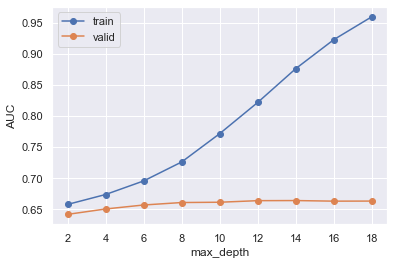

In [101]:
import matplotlib.pyplot as plt

plt.plot(max_depths, train_aucs,'o-',label = 'train')
plt.plot(max_depths, valid_aucs,'o-',label = 'valid')

plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.legend()
plt.show()

We can see that as we increase the `max_depth` the training performance is improved. Unfortunately, for this case, the validation performance does not change much. 

Since there are many hyperparameters for each model, there exist a few techniques to optimize the parameters automatically for you. 

One of those techniques is called Random Search.

As discussed in lecture, one technique for hyperparameter tuning is called a Grid search where you test all possible combinations over a grid of values. This is very computationally intensive. The other option is to randomly test a permutation of them. This technique called Random Search is also implemented in scikit-learn. Most of this section is based on this medium blog post (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)by William Koehrsen. I highly recommend following him on Towards Data Science. He writes high quality articles. 

In [102]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Let's create a grid over a few of these (see the scikit-learn website for the descriptions). 

In [103]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(2,20,2)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(2, 20, 2), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


To use the RandomizedSearchCV function, we need something to score or evaluate a set of hyperparameters. Here we will use the auc. 

In [104]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [105]:
# create a baseline model
rf = RandomForestClassifier()

# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, 
                               scoring=auc_scoring,verbose = 1, random_state = 42)

Three important parameters of `RandomizedSearchCV` are
- scoring = evaluation metric used to pick the best model
- n_iter = number of different combinations
- cv = number of cross-validation splits

increasing the last two of these will increase the run-time, but will decrease chance of overfitting.  Note that the number of variables and grid size also influences the runtime. Cross-validation is a technique for splitting the data multiple times to get a better estimate of the performance metric. For the purposes of this tutorial, we will restrict to 2 CV to reduce the time. 

In [106]:
import time
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.5min finished


163.15777111053467


See the best parameters

In [107]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'max_depth': 14,
 'criterion': 'entropy'}

Let's analyze the performance of the best model compared to the baseline model.

In [108]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline Random Forest')
rf_train_base_auc = roc_auc_score(y_train, y_train_preds)
rf_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_base_auc))
print('Validation AUC:%.3f'%(rf_valid_base_auc))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_opt_auc))
print('Validation AUC:%.3f'%(rf_valid_opt_auc))

Baseline Random Forest
Training AUC:0.681
Validation AUC:0.648
Optimized Random Forest


/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training AUC:0.867
Validation AUC:0.668


Note that in this case, we do get a boost of 0.02 on the Validation AUC. It looks like this Optimized Random Forest has massive overfitting, so it would be wise to employ some of the high-variance techniques to try to reduce it. 

Optimized SGDClassifier

In [109]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [110]:
penalty = ['none','l2','l1']
max_iter = range(200,1000,200)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/yash/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


16.956071138381958


In [111]:
sgdc_random.best_params_

{'penalty': 'l2', 'max_iter': 400, 'alpha': 0.01}

In [112]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline sgdc')
sgdc_train_base_auc = roc_auc_score(y_train, y_train_preds)
sgdc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_base_auc))
print('Validation AUC:%.3f'%(sgdc_valid_base_auc))

print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_opt_auc))
print('Validation AUC:%.3f'%(sgdc_valid_opt_auc))

Baseline sgdc
Training AUC:0.676
Validation AUC:0.661
Optimized sgdc
Training AUC:0.676
Validation AUC:0.661


Optimize Gradient Boosting Tree Classifier

In [113]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Note this one takes a long time, so work on your capstone project while this is computing. 

In [114]:
# number of trees
n_estimators = range(50,200,50)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

138.63847613334656


In [115]:
gbc_random.best_params_

{'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}

In [116]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline gbc')
gbc_train_base_auc = roc_auc_score(y_train, y_train_preds)
gbc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_base_auc))
print('Validation AUC:%.3f'%(gbc_valid_base_auc))
print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_opt_auc))
print('Validation AUC:%.3f'%(gbc_valid_opt_auc))

Baseline gbc
Training AUC:0.772
Validation AUC:0.638
Optimized gbc
Training AUC:0.735
Validation AUC:0.668


### Model Selection: analyze optimization results

Let's analyze the results of our 3 optimizations.

In [117]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB'],
                           'data_set':['baseline','optimized']*3,
                          'auc':[sgdc_valid_base_auc,sgdc_valid_opt_auc,
                                 rf_valid_base_auc,rf_valid_opt_auc,
                                 gbc_valid_base_auc,gbc_valid_opt_auc],
                          })

In [118]:
df_results

,classifier,data_set,auc
0,SGD,baseline,0.661396
1,SGD,optimized,0.660828
2,RF,baseline,0.648495
3,RF,optimized,0.668320
4,GB,baseline,0.638382
5,GB,optimized,0.667851


Plot the results

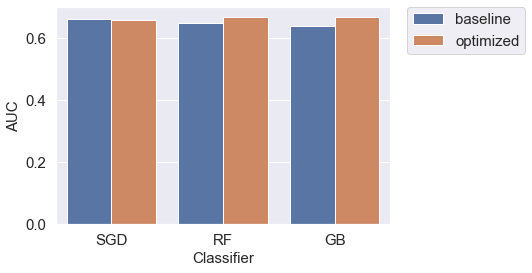

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

### Model Selection: Save your best classifier

You won't want to train your best classifier every time you want to run new predictions. Therefore, we need to save the classifier. We will use the package pickle. Here we will chose the stochastic gradient descent algorithm since it has the closest Training / Validation scores and performs about the same as the random forest and gradient boosting classifier. 

In [120]:
pickle.dump(sgdc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

# Model Evaluation

Now we are going to evaluate the performance of the best model on our test set. Note that to execute the code below. We need to execute the cells for the functions we defined above `calc_prevalence`, `fill_my_missing`, `calc_specificity`,`print_report`

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [122]:
# load the model, columns, mean values, and scaler
best_model = pickle.load(open('best_classifier.pkl','rb'))
cols_input = pickle.load(open('cols_input.sav','rb'))
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
scaler = pickle.load(open('scaler.sav', 'rb'))


In [123]:
# load the data
df_train = pd.read_csv('df_train.csv')
df_valid= pd.read_csv('df_valid.csv')
df_test= pd.read_csv('df_test.csv')

In [124]:
# fill missing
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)
df_test = fill_my_missing(df_test, df_mean_in, cols_input)

# create X and y matrices
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values
y_test = df_test['OUTPUT_LABEL'].values

# transform our data matrices 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

Calculate prediction probabilities

In [125]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

Evaluate the Performance

In [126]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.676
accuracy:0.625
recall:0.562
precision:0.643
specificity:0.688
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.656
recall:0.567
precision:0.179
specificity:0.668
prevalence:0.113
 
Test:
AUC:0.660
accuracy:0.650
recall:0.561
precision:0.181
specificity:0.662
prevalence:0.117
 


Plot the ROC curve

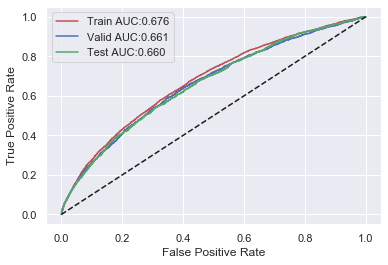

In [127]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()